In [17]:
from __future__ import division
from math import *
import numpy as np
import sys
import os
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogFormatterSciNotation

import pandas as pd
import numpy as np
import matplotlib, os
import matplotlib.pyplot as plt
# Matplotlib configuration
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.style.use('classic')
plt.rcParams['xtick.direction']     = 'in'
plt.rcParams['ytick.direction']     = 'in'
plt.rcParams['xtick.top']           = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.right']         = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import matplotlib.cm as cm

from matplotlib import pyplot
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amssymb}']}
pyplot.rcParams.update(params)

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import sys
sys.path.append("/Users/oozdal/packages/ma5-histo")
sys.path.append("/Users/oozdal/packages/ma5_expert")

import src.SafReader as sr
from CutFlowReader import Collection 

In [18]:
def df(fileLoc):
    data = sr.read(fileLoc=fileLoc)
    floatCols=['binMin', 'binMax', 'value']
    data[floatCols]  = data[floatCols].apply(pd.to_numeric, errors='coerce')
    data["bin"]      = (data.binMin+data.binMax)/2
    data             = data[data.binMax != np.inf]
    data             = data[data.binMin != -1*np.inf]
    data["binlabel"] = (data.binMin+data.binMax)/2
    return data

In [39]:
def unc(observable, Nevt):
    return np.sqrt((1-observable**2)/Nevt)

def sig(O1, O2, Nevt1, Nevt2):
    return abs(O1-O2)/np.sqrt( unc(O2,Nevt2)**2 ) # + O1*unc(O1,Nevt1)**2 )

In [19]:
lumi=3000.

# Standard Model 

In [42]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

SM = Collection(collection_path= AFB_data+'/SMll_Mll4500and8000/MadAnalysis5job_0/Cutflows',
                    saf_file       = AFB_data+'/SMll_Mll4500and8000/SMll_Mll4500and8000.saf',
                    lumi           = 3000.)
SM_sumw   = SM['Rap_No'][0].sumw
SM_histos = df(AFB_data+'/SMll_Mll4500and8000/MadAnalysis5job_0/Histograms/histos.saf')

In [43]:
SM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/SM.csv', header=0, sep=",")
SM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

Let's apply some bounds

In [44]:
SM_df = SM_df[ (SM_df["Mll"] >= 5400.)  & (SM_df["Mll"] <= 6600.) ]      # Mll [5-6] TeV
SM_df = SM_df[ (SM_df["Eta_lp"] <= 2.5) & (SM_df["Eta_lm"] <= 2.5) ]     # Eta(lepton) < 2.5
SM_df = SM_df[ (SM_df["Lepton_Charge"] < 0.) ]  # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for the SM

In [45]:
SM_AFB_pos = SM_df[ np.cos(SM_df["angle_CM_true"]) > 0. ]
SM_AFB_neg = SM_df[ np.cos(SM_df["angle_CM_true"]) < 0. ]

BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = SM_AFB_pos[:][ (SM_AFB_pos["Mll"]>bins[i]) & (SM_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = SM_AFB_neg[:][ (SM_AFB_neg["Mll"]>bins[i]) & (SM_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_SM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)

SM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_SM = TotEvWeight_LepPos_Arr2*lumi*SM.xsec*1000/SM_sumw
NumofEvents_LepNeg_SM = TotEvWeight_LepNeg_Arr2*lumi*SM.xsec*1000/SM_sumw

# LRSM

In [46]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

LRSM = Collection(collection_path= AFB_data+'/LRSMdilep_LO/MadAnalysis5job_0/Cutflows',
                    saf_file       = AFB_data+'/LRSMdilep_LO/LRSMdilep_LO.saf',
                    lumi           = 3000.)
LRSM_sumw   = LRSM['Rap_No'][0].sumw
LRSM_histos = df(AFB_data+'/LRSMdilep_LO/MadAnalysis5job_0/Histograms/histos.saf')

In [47]:
LRSM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/LRSMdilep_LO.csv', header=0, sep=",")
LRSM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

Let's apply some bounds

In [48]:
LRSM_df = LRSM_df[ (LRSM_df["Mll"] >= 5400.)  & (LRSM_df["Mll"] <= 6600.) ]      # Mll [5-6] TeV
LRSM_df = LRSM_df[ (LRSM_df["Eta_lp"] <= 2.5) & (LRSM_df["Eta_lm"] <= 2.5) ]     # Eta(lepton) < 2.5
LRSM_df = LRSM_df[ (LRSM_df["Lepton_Charge"] < 0.) ]  # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for LRSM

In [49]:
LRSM_df_AFB_pos = LRSM_df[ np.cos(LRSM_df["angle_CM_true"]) > 0. ]
LRSM_df_AFB_neg = LRSM_df[ np.cos(LRSM_df["angle_CM_true"]) < 0. ]

BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = LRSM_df_AFB_pos[:][ (LRSM_df_AFB_pos["Mll"]>bins[i]) & (LRSM_df_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = LRSM_df_AFB_neg[:][ (LRSM_df_AFB_neg["Mll"]>bins[i]) & (LRSM_df_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_LRSM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)

LRSM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos = TotEvWeight_LepPos_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw
NumofEvents_LepNeg = TotEvWeight_LepNeg_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw

# AFB Plotting for LRSM

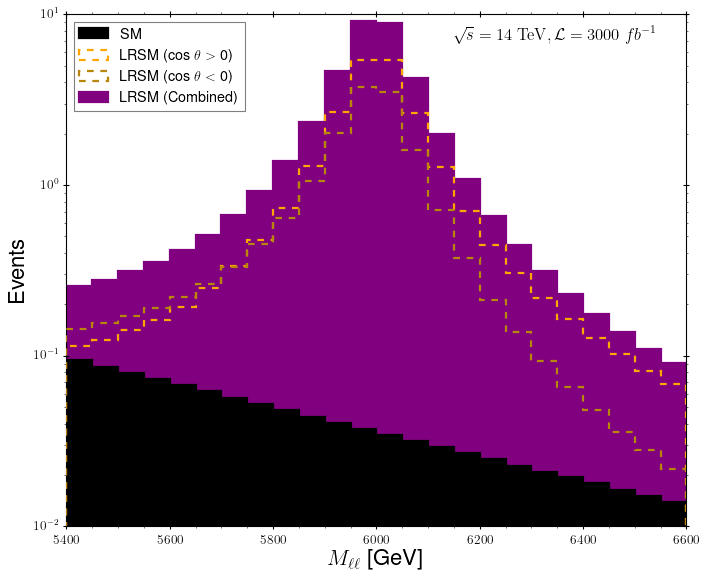

In [53]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)


fig, ax1 = plt.subplots()
fig.set_facecolor('white')
#plt.title(r"$E_6 - \psi$ Model", fontsize=20)
plt.hist(binlabel,bins=bins,
             label=r'SM', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM, facecolor="black",
             color=None, edgecolor='black', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=5)
plt.hist(binlabel,bins=bins,
             label=r'LRSM (cos $\theta > $ 0)', histtype="step", rwidth=1.0,
             weights=NumofEvents_LepPos, facecolor="orange",
             color=None, edgecolor='orange', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=7)
plt.hist(binlabel,bins=bins,
             label=r'LRSM (cos $\theta < $ 0)', histtype="step", rwidth=1.0,
             weights=NumofEvents_LepNeg, facecolor="darkgoldenrod",
             color=None, edgecolor='darkgoldenrod', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=8)
plt.hist(binlabel,bins=bins,
             label=r'LRSM (Combined)', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepPos+NumofEvents_LepNeg, facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)
plt.xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
plt.ylabel('Events' , fontsize=20)
#plt.xscale('log')
plt.yscale('log')

ax1.text(6150, 7, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)


leg = ax1.legend(loc='upper left',fontsize=13) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
#ax1.set_ylim([1e-4,1e1])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")

plt.show()

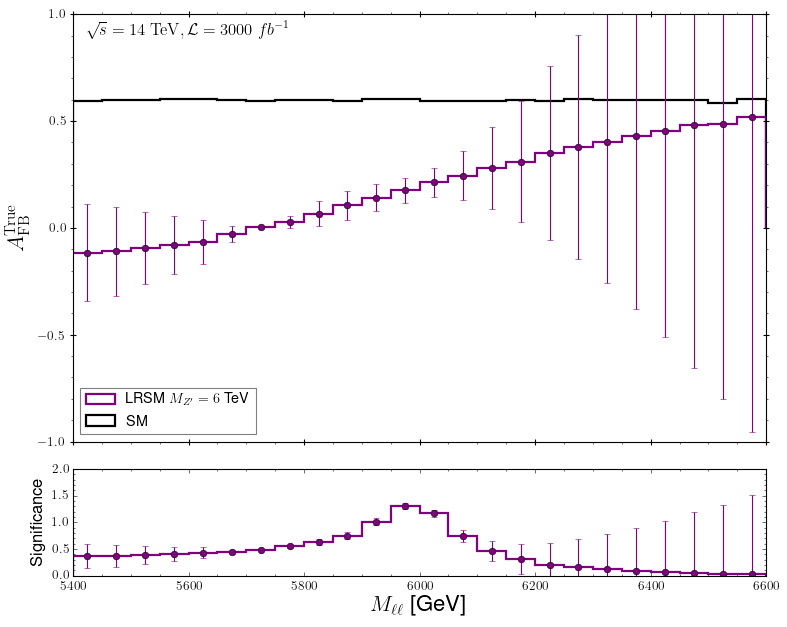

In [54]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)


fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
fig.set_facecolor('white')
#plt.title(r"$E_6 - \eta$ Model", fontsize=20)
ax1.hist(binlabel,bins=bins,
             label=r"LRSM $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
             weights=AFB_LRSM, facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)
ax1.hist(binlabel,bins=bins,
             label=r"SM", histtype="step", rwidth=1.0,
             weights=AFB_SM, facecolor="black",
             color=None, edgecolor='black', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)


#ax1.errorbar(binlabel, AFB_SM, yerr=AFB_SM*unc(AFB_SM,NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), linestyle='None', marker='o')
ax1.errorbar(binlabel, AFB_LRSM, yerr=AFB_LRSM*unc(AFB_LRSM,(NumofEvents_LepPos+NumofEvents_LepNeg)), linestyle='None', marker='o', color='purple')

#ax1.set_xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
ax1.set_ylabel(r'$A_{\rm FB}^{\rm True}$' , fontsize=20)
#ax1.set_yscale('log')

ax1.text(5425, 0.90, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)

leg = ax1.legend(loc='lower left',fontsize=13) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
ax1.set_ylim([-1.0,1.0])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")


ax2.hist(binlabel,bins=bins,
             label=r'LRSM (Combined)', histtype="step", rwidth=1.0,
             weights=sig(AFB_SM, AFB_LRSM, (NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), (NumofEvents_LepPos+NumofEvents_LepNeg)), facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

ax2.errorbar(binlabel, sig(AFB_SM, AFB_LRSM, (NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), (NumofEvents_LepPos+NumofEvents_LepNeg)), yerr=AFB_LRSM*unc(AFB_LRSM,(NumofEvents_LepPos+NumofEvents_LepNeg)), linestyle='None', marker='o', color='purple')
ax2.set_ylim([0,2.0])

ax2.set_xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
ax2.set_ylabel(r'Significance' , fontsize=15)

fig.tight_layout()

plt.show()